In [60]:
from silx.io import specfile as spec # migrated from PyMca5!
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib as mpl
import scipy.ndimage as nd
from skimage import filters, exposure, restoration, morphology, feature, measure
import lib.calc as c
import lib.kmap as k
from ipywidgets import interact
from scipy.signal import savgol_filter
import peakutils as pk
import fabio


%matplotlib qt5

In [61]:
mpl.rcParams['font.size'] = 8

In [62]:
def sum3dkmap(fname, rois):
    kmapallrois = []
    kmapall = []
    n_scans = int(len(sf.list()))
    print('n of scans: {0}'.format(n_scans))
    
    for roi in rois:
        for scan in range(0,n_scans-1):
            kmap = k.read_kmap(fname, scan, [roi], motors=True)
            img = kmap[roi]
            kmapall.append([img][0])
        kmapallrois.append(kmapall)
    piy, pix = kmap['motors'][0], kmap['motors'][1]
    
    kmapsumrois = np.zeros(kmapall[0].shape)
    for index in range(len(kmapallrois)):
        kmapsum = np.zeros(kmapall[0].shape)
        for index in range(len(kmapall)):
            kmapsum = kmapsum + kmapall[index]
        kmapsumrois = kmapsumrois + kmapsum
        
    return pix, piy, kmapsumrois

In [63]:
def plot_kmap(specfile, scan_no, rois, log=False, axeslabels=False, **kwargs):
    """ Only to be used within this nb for now!"""
    # get the data 
    data = specfile[scan_no].data
    # get the spec indexes (list)
    index_list = specfile.labels(scan_no)
    # other
    sfname = specfile.file_header(0)[0][::-1][21::-1]
    thx = specfile[scan_no].motor_position_by_name('thx')
    thy = specfile[scan_no].motor_position_by_name('thy')
    phi = specfile[scan_no].motor_position_by_name('phi')
    eta = np.round(specfile[scan_no].motor_position_by_name('eta'), decimals=3)
    delval = np.round(specfile[scan_no].motor_position_by_name('del'), decimals=3)
    
    fig = plt.figure(edgecolor='red',**kwargs)
    fig.suptitle('{0} #{1}'.format(sfname, scan_no))
    grid = ImageGrid(fig, 111,
                    nrows_ncols=(1,len(rois)),
                    axes_pad = 0.1,
                    cbar_mode = 'each',
                    cbar_size = '2%',
                    cbar_pad = '2%',
                    cbar_location = 'top')
    
    for index, roi in enumerate(rois):
        # load data
        rawdata =  data[index_list.index(roi)]
        rawdata[rawdata > 1e8] = 1
        # load motor positions
        motor_1 = data[index_list.index('adcX')]
        motor_2 = data[index_list.index('adcY')]
        command = specfile.command(scan_no).split()
        new_shape = (int(command[8]), int(command[4]))
        # apply dimensions
        rawdata.shape, motor_1.shape, motor_2.shape = new_shape, new_shape, new_shape
        # plot it
        if not log:
            i = rawdata
        else:
            i = np.log(rawdata)
        im = grid[index].pcolormesh(motor_1, motor_2, i, cmap='viridis')
        im.axes.set_aspect('equal')
        if axeslabels:
            grid[index].set_ylabel(r'x piezo [$\mu m$]',fontsize=8)
            grid[index].set_xlabel(r'y piezo [$\mu m$]',fontsize=8)
        grid[index].set_title('{0}'.format(roi), pad=30,fontdict={'fontsize':9, 'fontweight':'bold'})
        cbar = grid.cbar_axes[index].colorbar(im)
        cbar.ax.tick_params(labelsize=8)
        
        plt.gcf().text(0.54, 0.01, 'eta={0}; del={1}; phi={2}\nthx={3}; thy={4}'.format(eta, delval, phi, thx, thy), 
                       size=10, weight='normal', va='top', ha='center', bbox=dict(boxstyle="round", facecolor='orange', alpha=0.1))
        plt.tight_layout()
        
    plt.show()

In [168]:
# Initialise some variables
specdir = '/data/id01/inhouse/leake/hc2912/id01/spec/'
sample_name = 'E16095'
# See kmap specfiles corresponding to specified sample name
specfiles = !ls {specdir} | grep spec | grep _fast | grep -i {sample_name}
for index, fname in enumerate(specfiles): print(str(index)+'...'+str(fname))

0...E16095_furnace_2_fast_00010.spec
1...E16095_furnace_2_fast_00028.spec
2...E16095_furnace_2_fast_00054.spec
3...E16095_furnace_fast_00033.spec
4...E16095_furnace_fast_00045.spec
5...E16095_furnace_fast_00046.spec
6...E16095_furnace_fast_00047.spec
7...E16095_furnace_fast_00048.spec
8...E16095_furnace_fast_00218.spec
9...E16095_furnace_fast_00220.spec


In [169]:
# specify fil2num to inspect
i = 5
fname = specdir+specfiles[i]
sf = spec.SpecFile(fname)
n_scans = int(len(sf.list()))
print('{0} --> {1} scans'.format(specfiles[i],n_scans))

E16095_furnace_fast_00046.spec --> 122 scans


interactive(children=(IntSlider(value=0, description='i', max=121), Output()), _dom_classes=('widget-interact'…

/users/zatterin/Envs/py3/lib/python3.5/site-packages/matplotlib/colors.py:916: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/users/zatterin/Envs/py3/lib/python3.5/site-packages/numpy/ma/core.py:716: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


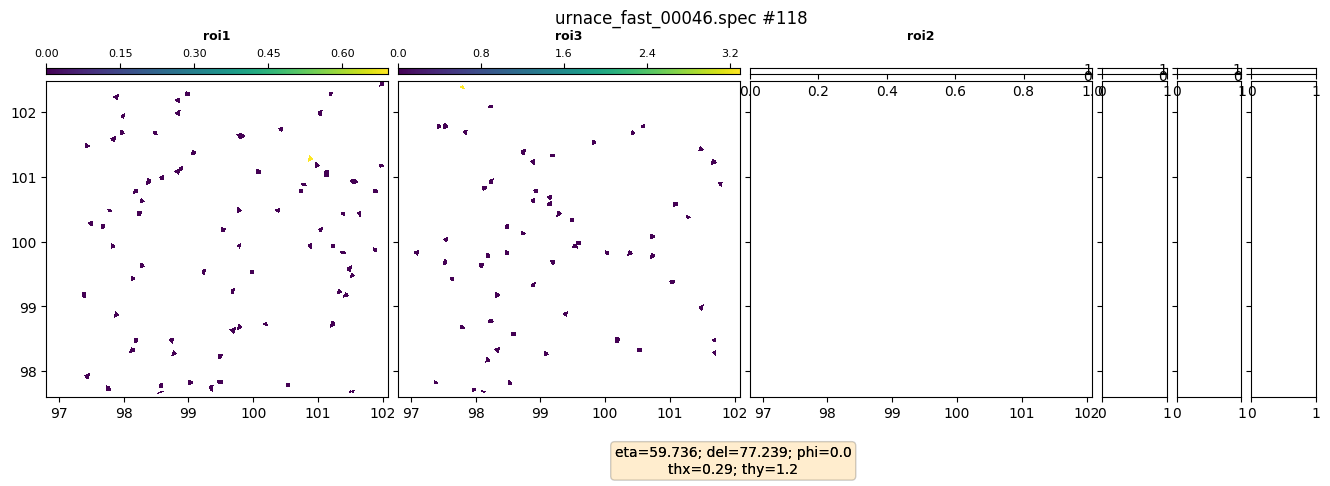

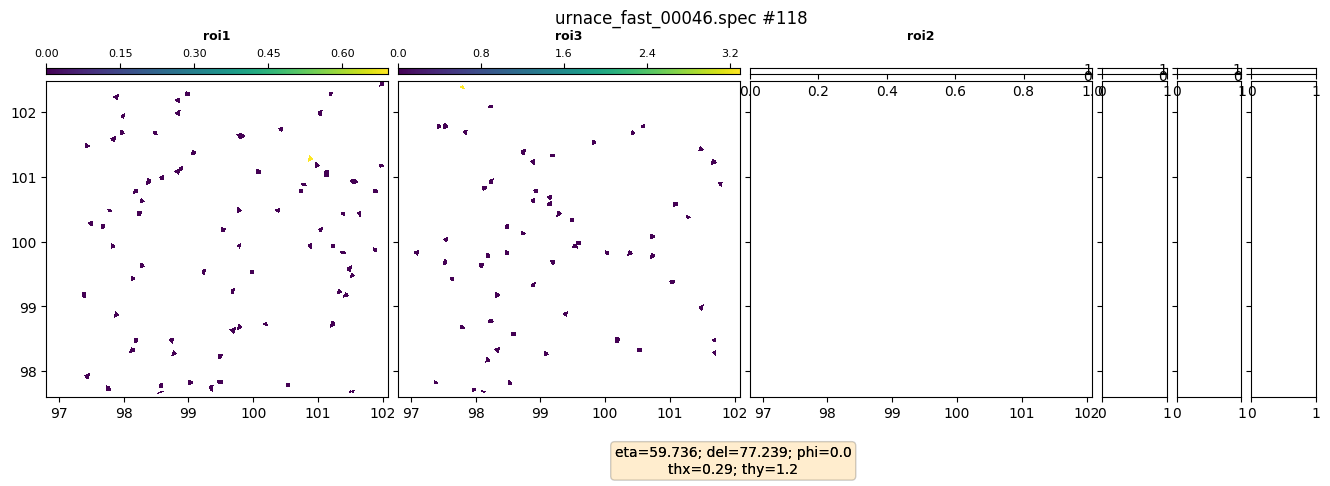

In [247]:
%matplotlib inline
rois = ['roi1','roi3','roi2','roi4','mpx4ro1','mpx4ro2']

@interact(i=(0,n_scans-1,1))
def scroll_scans(i=0):
    plot_kmap(sf,i,rois,log=True,figsize=(13,4.5),dpi=100)#,facecolor='lightgrey')

In [ ]:
# specify filenum to inspect
i = 4
fname = specdir+specfiles[i]
sf = spec.SpecFile(fname)
n_scans = int(len(sf.list()))
print('{0} --> {1} scans'.format(specfiles[i],n_scans))

In [ ]:
%matplotlib inline
rois = ['roi1','roi2','roi3','roi5']

@interact(i=(0,n_scans-1,1))
def scroll_scans(i=9):
    plot_kmap(sf,i,rois,log=True,figsize=(10.5,5),dpi=80)

In [ ]:
# sum rois 
n = 3

kmapallrois = []
for roi in rois:
    kmap = k.read_kmap(fname, n, [roi], motors=True)
    img = kmap[roi]
    kmapallrois.append(img)
piy, pix = kmap['motors'][0], kmap['motors'][1]

kmapsum = np.zeros(kmapallrois[0].shape)
for index in range(len(kmapallrois)):
    kmapsum = kmapsum + kmapallrois[index]
    
%matplotlib inline
plt.figure(dpi=150)
plt.pcolormesh(piy, pix, np.log(kmapsum))
plt.axis('image')
plt.xlabel('piy')
plt.ylabel('pix')
plt.colorbar()
plt.title('{0} -- sum ROIs #{1}'.format(specfiles[i],n),fontsize=8)

## Sum all imgs in 3dkmap

In [ ]:
# Initialise some variables
d = '/data/id01/inhouse/IHR/ihhc3501/mdata/hc3501/id01/AuSiC5/'
sample_name = 'KMAP'

# See kmap specfiles corresponding to specified sample name
dirs = !ls {d} | grep -i {sample_name}
for index, fname in enumerate(dirs): print(str(index)+'...'+str(fname))

In [ ]:
# specify filenum to inspect
i = 27

specdir = d+dirs[i]+'/spec/'
specfilename = !ls {specdir} | grep spec | grep fast
fname = specdir+specfilename[0]
sf = spec.SpecFile(fname)
n_scans = int(len(sf.list()))
print('{0} --> {1} scans'.format(specfilename[0],n_scans))

In [ ]:
%matplotlib inline
rois = ['roi1','roi2','roi3','roi5']

@interact(i=(0,n_scans-1,1))
def scroll_scans(i=0):
    plot_kmap(sf,i,rois,log=True,figsize=(10.5,5),dpi=100)
    plt.show()

In [ ]:
rois = ['roi1','roi2','roi3','roi5']

pix, piy, kmapsumrois = sum3dkmap(fname,rois)

In [ ]:
%matplotlib inline
plt.figure(dpi=150)
plt.pcolormesh(piy, pix, kmapsumrois)
plt.axis('image')
plt.xlabel('piy')
plt.ylabel('pix')
plt.colorbar()
thx = sf[0].motor_position_by_name('thx')
thy = sf[0].motor_position_by_name('thy')
phi = sf[0].motor_position_by_name('phi')
plt.suptitle('thx={0}, thy={1}, phi={2}'.format(thx, thy, phi))
plt.title(specfilename[0] + '...sum all imgs', fontsize=6)

## Interact & other calc

In [7]:
kmap = k.read_kmap(fname, 6, rois, motors=True)
piy, pix = kmap['motors'][0], kmap['motors'][1]
i = kmap[rois[0]]

In [30]:
class LineProjection(object):
    def __init__(self, img, ax, i, q1, q2, n, t):
        self.img = img
        self.q1 = q1
        self.q2 = q2
        self.data = i[:-1,:-1]#np.array(img.get_array()).reshape(img._meshHeight,img._meshWidth)
        self.cidclick = img.figure.canvas.mpl_connect('button_press_event', self.on_press)
        self.cidrelease = img.figure.canvas.mpl_connect('button_release_event', self.on_release)
        self.ax = ax
        self.n = n
        self.t = t
        
    def on_press(self,event):
        self.press = event.xdata, event.ydata    
        if event.inaxes != self.img.axes: return
        print('pressed: {0}'.format(self.press))
        
    def on_release(self,event):
        global x, y, Icut, box, mask, maskimg
        
        start_q1, start_q2 = self.press
        end_q1, end_q2 = event.xdata, event.ydata
        print('released: {0}, {1}'.format(end_q1, end_q2))

        
        # Make array of qx, qy values along line        
        x = np.linspace(start_q1,end_q1,self.n) 
        y = np.linspace(start_q2,end_q2,self.n)
        
        # Calc
        ind = np.sqrt((q2[:-1,:-1].ravel() - y[:,None])**2 + (q1[:-1,:-1].ravel() - x[:,None])**2) < (self.t) #min along column
        Icut = ((self.data.ravel() * np.ones(ind.shape[0])[:,None]) * ind).sum(1)
        box = ind.max(0).reshape(self.data.shape)
        mask = np.ma.masked_where(box==1, box)
        
        # Plot img and cut line - ax0
        if len(self.img.axes.lines) == 0:
            self.img.axes.plot([start_q1, end_q1], [start_q2, end_q2])
        else:
            self.img.axes.lines[0].set_data([start_q1, end_q1], [start_q2, end_q2])
        self.img.figure.canvas.draw_idle()
            
        # Show integrated area - ax1
        self.ax[1].clear()
        self.ax[1].pcolormesh(q1,q2,np.log(i))
        self.ax[1].pcolormesh(q1,q2,mask,alpha=0.2)
        self.ax[1].set_aspect('equal')
        self.ax[1].set_title('Box being integrated')
        self.ax[1].figure.canvas.draw_idle()
            
        # Draw Lines - ax2
        self.ax[2].clear()
        self.ax[2].plot((np.sqrt(x**2+y**2)),Icut)
        self.ax[2].set_xlabel(r'$|Q_{xy}|$')
#         self.ax[2].set_yscale('log')
        self.ax[2].set_title('Integrated profile')
        self.ax[2].figure.canvas.draw_idle()

In [32]:
%matplotlib qt5

fig, ax = plt.subplots(1,3,figsize=(10,5),dpi=100)

q1 = piy
q2 = pix

img = ax[0].pcolormesh(q1,q2,i)
ax[0].set_aspect('equal')
ax[0].set_title('Drag to select line cut')
test = LineProjection(img,ax,i,q1,q2,200,1)

Text(0.5,0,'length in $\\mu m$')

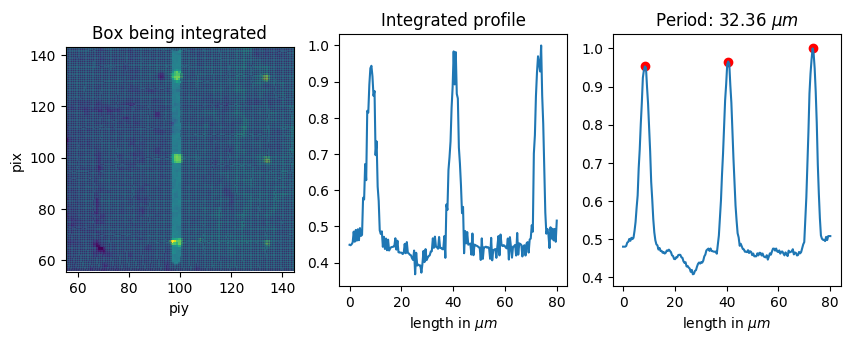

In [104]:
%matplotlib inline
n = 200
res = 100

# Select cut coordinates
start_q1, start_q2 = 98, 140
end_q1, end_q2 = 98, 60 

# Make array of qx, qy values along line        
x = np.linspace(start_q1,end_q1,n) 
y = np.linspace(start_q2,end_q2,n)

# Data
q1 = piy
q2 = pix
I = i[:-1,:-1]

# Calc
ind = np.sqrt((q2[:-1,:-1].ravel() - y[:,None])**2 + (q1[:-1,:-1].ravel() - x[:,None])**2) < (2) #min along column
Icut_xy = ((I.ravel() * np.ones(ind.shape[0])[:,None]) * ind).sum(1)
box = ind.max(0).reshape(I.shape)
mask = np.ma.masked_where(box==1, box)
line = np.sqrt((x-x.min())**2+(y-y.max())**2)

## Calc
Ismooth = savgol_filter(Icut_xy,5,0)
idx = pk.indexes(Ismooth,thres=0.5,min_dist=10)
# The periodicity - calc
order = np.array(range(len(idx)))
m,b = np.polyfit(order,line[idx],1)


# Plot
fig, ax = plt.subplots(1,3,figsize=(12/1.2, 4/1.2),dpi=res)#,facecolor='lightgrey')
# fig.suptitle('hc3211 - {0} #{1} | 203 proj. Qz'.format(sample, scans))

ax[0].pcolormesh(q1,q2,np.log(I))
ax[0].pcolormesh(q1,q2,mask,alpha=0.2)
ax[0].set_title('Box being integrated')
ax[0].set_aspect('equal')
ax[0].set_xlabel('piy')
ax[0].set_ylabel('pix')

ax[1].plot(line,Icut_xy/Icut_xy.max())
ax[1].set_title('Integrated profile')
ax[1].set_xlabel(r'length in $\mu m$')

ax[2].plot(line, Ismooth/Ismooth.max())
ax[2].scatter(line[idx],Ismooth[idx]/Ismooth.max(),c='r')
ax[2].set_title(r'Period: {0} $\mu m$'.format(np.round(m,decimals=2)))
ax[2].set_xlabel(r'length in $\mu m$')

## Look at some raw imgs

In [192]:
d = '/data/id01/inhouse/leake/hc2912/id01/detector/E16095_furnace_kmap/'
img_list = !ls {d}
first_img = img_list[0]
n_files = !ls {d} -F |grep -v / | wc -l
n_files = int(n_files[0])

print(first_img)

kmap100000.edf.gz


In [193]:
fname = '/data/id01/inhouse/leake/hc2912/id01/spec/E16095_furnace_fast_00046.spec'
sf = spec.SpecFile(fname)
scan_no = 41

scan = sf['{0}.1'.format(scan_no)]
print(scan.scan_header_dict['ULIMA_mpx4'])

KeyError: 'ULIMA_mpx4'

In [194]:
print(sf.command(scan_no-1))

pscando pix 97.6 102.6 100 piy 97.5 102.5 100 0.020 fs


In [164]:
eta_start = 52.3361 
eta_end = 60.3361  
n_steps = 300 
eta_step = (eta_end-eta_start)/n_steps

In [166]:
%matplotlib inline

img = fabio.open(d+first_img)
n = 19489
m = 22752

@interact(i=(0, n_steps, 1))
def plot(i=0):
    plt.imshow(np.log(img.getframe(i+m).data))
    e = eta_start + i*(eta_step)
    plt.text(530,30,e,fontdict={'fontsize':20})

interactive(children=(IntSlider(value=0, description='i', max=300), Output()), _dom_classes=('widget-interact'…

## Sum all detector images in a kmap

In [238]:
fname = '/data/id01/inhouse/leake/hc2912/id01/spec/E16095_furnace_fast_00046.spec'
sf = spec.SpecFile(fname)
scan_no = 40

scan = sf['{0}.1'.format(scan_no)]
print(scan.header[106])
print(sf.command(scan_no))

#C imageFile dir[/data/visitor/hc2912/id01/detector/E16095_furnace_kmap] prefix[kmap1] idxFmt[%05d] nextNr[46] suffix[.edf.gz]
pscando pix 97.6 102.6 100 piy 97.5 102.5 100 0.020 fs


In [214]:
d = '/data/id01/inhouse/leake/hc2912/id01/detector/E16095_furnace_kmap/'
img_list = !ls {d}
first_img = img_list[0]
n_files = !ls {d} -F |grep -v / | wc -l
n_files = int(n_files[0])

print(first_img)

kmap100000.edf.gz


In [243]:
img = fabio.open(d+img_list[27])
@interact(i=(0, img.nframes-1, 1))
def plot(i=0):
    plt.imshow(np.log(img.getframe(i).data))

interactive(children=(IntSlider(value=0, description='i', max=9999), Output()), _dom_classes=('widget-interact…

In [244]:
imglist = []
for frame in range(0, img.nframes):
    imglist.append(img.getframe(frame).data)

In [245]:
imgsum = np.zeros((516,516))
for img in imglist:
    imgsum = imgsum+img

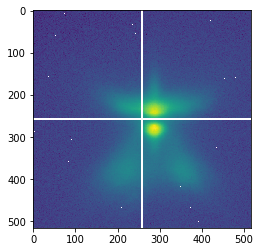

In [246]:
plt.imshow(np.log(imgsum))

In [236]:
np.save('fast46_s{0}'.format(), imgsum)

### Strategy

* Check that ROIs correspond to what shown in .png image. Might not be necessary if I decide to make new ones anyway.
* Save the image sum (as done above) for all the angles in the 3d kmap. 
* Inspect those images and decide which new ROIs to define
* Make the rois
* Re-plot the kmaps within the 3dkmap with this new rois
* Decide a range which is interesting and drift is not crazy
* Use these for xsocs / try to understand something from it.